# 1 Problem description

The aim of this data exercise is to test a data source, called 'Signal', which claims to be predictive of future returns of the SP500 index (use SPY as a proxy).

There will be two main parts in the following text.
    - Data cleaning: identify any errors in the data
    - Time series analysis: to check if 'Signal' could be used to predict future values of 'ClosePrice' of SP500.

In [1]:
import pandas as pd
import pandas_market_calendars as mcal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

Import data from the excel file:

In [2]:
df = pd.read_excel("ResearchDatasetV2.0.xlsx")#,index_col='Date')
print(df.head ())

       Date    Signal  ClosePrice
0  20120103  3.107767     127.495
1  20120104  3.107282     127.700
2  20120105  3.099757     128.040
3  20120106  3.134223     127.710
4  20120109  3.135922     128.020


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 3 columns):
Date          667 non-null int64
Signal        667 non-null float64
ClosePrice    667 non-null float64
dtypes: float64(2), int64(1)
memory usage: 15.7 KB
None


There are three columns in the dataframe:
- Date
- Signal, which may be predictive of future returns of the SP500 index (use SPY as a proxy) 
- Close price, which is the SPY price

# 1 Data Cleaning

Firstly, Let's check if there are missing values.

In [4]:
print(df.isna().any())
print(df.isnull().any())

Date          False
Signal        False
ClosePrice    False
dtype: bool
Date          False
Signal        False
ClosePrice    False
dtype: bool


There is no missing value. let's convert type of the Date column from int64 to datetime format

In [5]:
df['Date'] = pd.to_datetime(df['Date'],format='%Y%m%d',utc=True)

Then we add a column "Day of Week" to the dataframe

In [6]:
df['Day of Week'] = df['Date'].dt.weekday_name

Let's check if the dates are unique

In [7]:
print(df['Date'].is_unique)

True


We get the calendar of trading days for the date range of dataframe df

In [8]:
nyse = mcal.get_calendar('NYSE')
val_day = nyse.valid_days(start_date=min(df.Date), end_date=max(df.Date))

Let's check if all the dates are trading days

In [9]:
wrong_date= df[~df['Date'].isin(val_day)]
print(wrong_date)

                         Date    Signal  ClosePrice Day of Week
494 2013-12-25 00:00:00+00:00  4.439806      182.93   Wednesday
499 2014-01-01 00:00:00+00:00  4.454369      184.69   Wednesday
525 2014-02-08 00:00:00+00:00  4.466505      179.68    Saturday
526 2014-02-09 00:00:00+00:00  4.466505      179.68      Sunday


We can see there are 4 days which are illegal. 2013-12-25 is Christmas Day, 2014-01-01 is New Year's Day. 2014-02-08 and 2014-02-09 are weekends. So we dope them with their corresponding rows.

In [10]:
df = df[df['Date'].isin(val_day)]

Let's check if there are missing trading dates in the dataframe:

In [11]:
days = val_day[~val_day.isin(df['Date'])]
print("The %d missing dates are:"%(len(val_day)-df.shape[0]))
[print(item) for item in days.strftime('%Y-%m-%d')]

The 6 missing dates are:
2013-01-14
2013-01-15
2013-01-16
2013-01-17
2014-01-06
2014-02-11


[None, None, None, None, None, None]

We interpolate the missing values

In [12]:
print(df.set_index('Date')['2013-01-11':'2013-01-20'])
df = df.set_index('Date').reindex(val_day).interpolate()
print(df['2013-01-11':'2013-01-20'])

                             Signal  ClosePrice Day of Week
Date                                                       
2013-01-11 00:00:00+00:00  3.569660      147.07      Friday
2013-01-18 00:00:00+00:00  3.625485      148.33      Friday
                             Signal  ClosePrice Day of Week
2013-01-11 00:00:00+00:00  3.569660     147.070      Friday
2013-01-14 00:00:00+00:00  3.580825     147.322         NaN
2013-01-15 00:00:00+00:00  3.591990     147.574         NaN
2013-01-16 00:00:00+00:00  3.603155     147.826         NaN
2013-01-17 00:00:00+00:00  3.614320     148.078         NaN
2013-01-18 00:00:00+00:00  3.625485     148.330      Friday


The 4 NaNs above should be Monday, Tuesday, Wednesday and Thursday.

Then Let's check if there are outliers in the Signal column

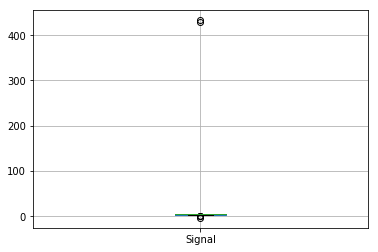

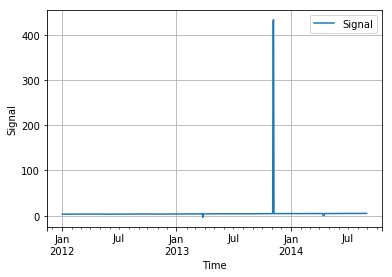

In [13]:
df.boxplot('Signal')
df.plot(x=df.index, y='Signal')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.grid()

From the figures above, we can see there are 2 data points which are significantly larger than others. They are:

In [14]:
wrong_signal_l = df[df['Signal'] > 400]
print(wrong_signal_l)

                               Signal  ClosePrice Day of Week
2013-11-05 00:00:00+00:00  429.514563      176.27     Tuesday
2013-11-06 00:00:00+00:00  432.961165      177.17   Wednesday


Let's replace them with interpolated values and check again:

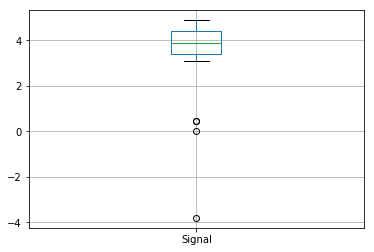

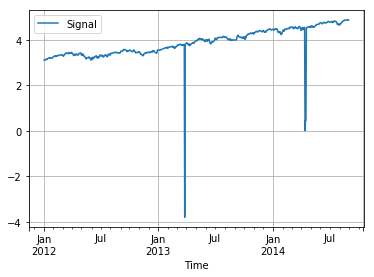

In [15]:
df.loc[df['Signal']>400,'Signal'] = np.nan
df['Signal'] = df['Signal'].interpolate()
df.boxplot("Signal")
df.plot(x=df.index, y='Signal')
plt.xlabel('Time')
plt.grid()

Again, there are also a few data points which are significantly smaller than others. They are:

In [16]:
wrong_signal_s = df[df['Signal']<2]
print(wrong_signal_s)

                             Signal  ClosePrice Day of Week
2013-03-26 00:00:00+00:00 -3.802670    156.1900     Tuesday
2014-04-14 00:00:00+00:00  0.004560    182.9401      Monday
2014-04-15 00:00:00+00:00  0.454976    184.2000     Tuesday
2014-04-16 00:00:00+00:00  0.455898    186.1250   Wednesday


Let's replace them with interpolated values and then we get the figure of time series 'Signal'.

count    669.000000
mean       3.913538
std        0.523309
min        3.099757
25%        3.422816
50%        3.893689
75%        4.405583
max        4.881311
Name: Signal, dtype: float64


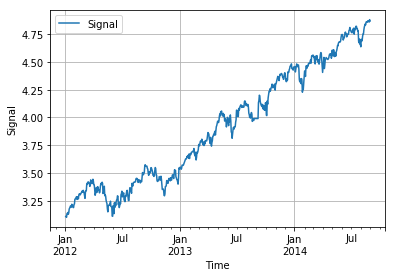

In [17]:
df.loc[df['Signal']<2,'Signal'] = np.nan
df['Signal'] = df['Signal'].interpolate()
print(df['Signal'].describe())
df.plot(x=df.index, y='Signal')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.grid()

We can do the same thing for the ClosePrice column

Text(0, 0.5, 'ClosePrice')

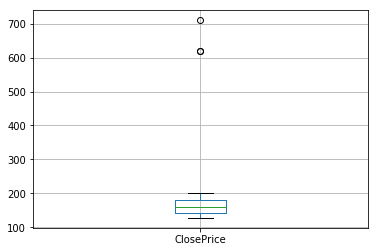

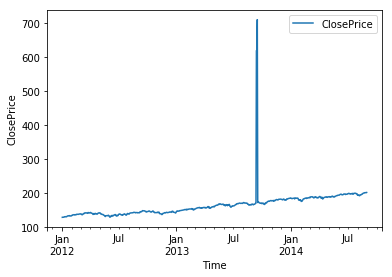

In [18]:
df.boxplot("ClosePrice")
df.plot(x=df.index, y='ClosePrice')
plt.xlabel('Time')
plt.ylabel('ClosePrice')

In [19]:
wrong_ClosePrice = df[df['ClosePrice']>600]
print(wrong_ClosePrice)

                             Signal  ClosePrice Day of Week
2013-09-12 00:00:00+00:00  4.193204      618.95    Thursday
2013-09-13 00:00:00+00:00  4.143689      619.33      Friday
2013-09-16 00:00:00+00:00  4.124515      710.31      Monday


count    669.000000
mean     160.874214
std       21.392170
min      127.495000
25%      140.910000
50%      159.300000
75%      181.000000
max      200.710000
Name: ClosePrice, dtype: float64


Text(0, 0.5, 'ClosePrice')

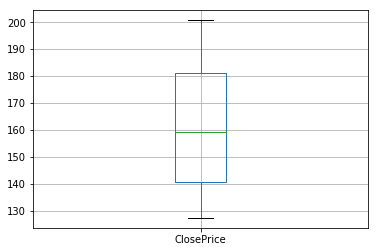

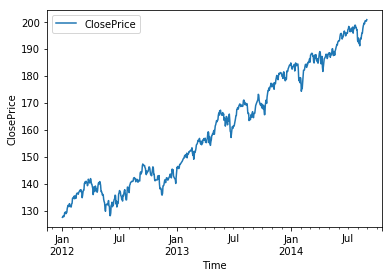

In [20]:
df.loc[df['ClosePrice']>600,'ClosePrice'] = np.nan
df['ClosePrice'] = df['ClosePrice'].interpolate()
print(df['ClosePrice'].describe())
df.boxplot("ClosePrice")
df.plot(x=df.index, y='ClosePrice')
plt.xlabel('Time')
plt.ylabel('ClosePrice')

Finally, We drop the column "Day of Week"

In [21]:
df = df.drop(columns='Day of Week')

Finally, Let's plot Signal and ClosePrice on top of each other

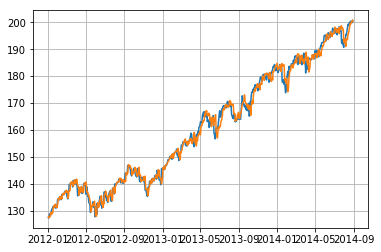

In [22]:
plt.plot(df['Signal']*41.12,label="Signal*41.12")
plt.plot(df['ClosePrice'],label="Closeprice")
plt.grid()
plt.show()

Note that 'ClosePrice' is approximately 40 times bigger than 'Signal'.

# 2 Time series

It seems that 'Signal' may be used to predict 'ClosePrice'. Let's first have a glance on the decomposition plot on 'Signal'.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


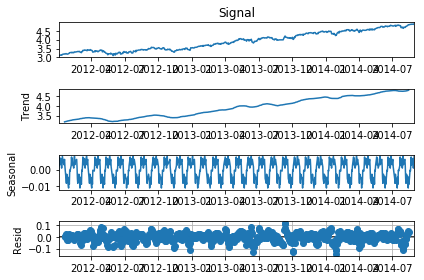

In [23]:
decomposition = seasonal_decompose(df['Signal'],freq=22)
fig = decomposition.plot()
plt.grid()
plt.show()

### 2.1 Check Stationary

From the figures above we can see that the time series is not stationary. Let's confirm this using Augmented Dickey Fuller (ADF) Test

In [24]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of ADF Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

#apply adf test on the series
adf_test(df['Signal'])

Results of ADF Test:
Test Statistic                  -0.306330
p-value                          0.924603
#Lags Used                       2.000000
Number of Observations Used    666.000000
Critical Value (1%)             -3.440207
Critical Value (5%)             -2.865889
Critical Value (10%)            -2.569086
dtype: float64


The test statistic is bigger than the critical values, which implies that the time series 'Signal' is not stationary.

Let's try Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test to check it again

In [25]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print(kpss_output)
kpss_test(df['Signal'])

Results of KPSS Test:
Test Statistic            3.241585
p-value                   0.010000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


With the test statistic bigger than the critical values, we reject the null hypothesis, which confirms again that the time series 'Signal' is not stationary. The p-value is less than 0.05. 

Next, let’s do a quick differencing on the column 'Signal' to make the time series stationary.

Results of ADF Test:


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Test Statistic                 -20.202023
p-value                          0.000000
#Lags Used                       1.000000
Number of Observations Used    666.000000
Critical Value (1%)             -3.440207
Critical Value (5%)             -2.865889
Critical Value (10%)            -2.569086
dtype: float64
Results of KPSS Test:
Test Statistic            0.050405
p-value                   0.100000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


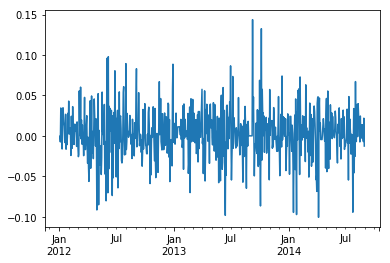

In [26]:
df['Signal_diff'] = df['Signal'] - df['Signal'].shift(1)
df['Signal_diff'].dropna().plot()
adf_test(df['Signal_diff'].dropna())
kpss_test(df['Signal_diff'].dropna())

Both ADF test and KPSS test imply that the time series 'Signal_log_diff' is stationary. 

### 2.2 ARIMA Model

Firstly, let's have a look at the Auto Correlation Function (ACF) figure and Partial Auto Correlation Function (PACF) figure of 'Signal_diff'.

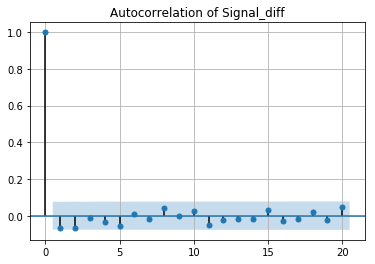

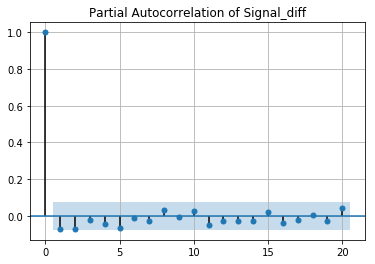

In [27]:
plot_acf(df['Signal_diff'].dropna(), lags=20)
plt.grid()
plt.title('Autocorrelation of Signal_diff')
plt.show()
plot_pacf(df['Signal_diff'].dropna(), lags=20)
plt.grid()
plt.title('Partial Autocorrelation of Signal_diff')
plt.show()

We can conclude that p = q = 2 is a good choice to fit 'Signal_diff' using ARIMA Model. We set d = 1 since we  did a differencing on the column 'Signal'. However, We find that p = q = 1 has lower AIC. So we try (p,d,q) = (1,1,1)

In [28]:
class Arima_model:
    def __init__(self,ts,order):
        # fit model
        self.order = order
        model = ARIMA(ts, order=order)
        '''
        self.model = pm.auto_arima(ts, start_p=1, start_q=1,
                                   test='adf',       # use adftest to find optimal 'd'
                                   max_p=4, max_q=4, # maximum p and q
                                   m=1,              # frequency of series
                                   d=None,           # let model determine 'd'
                                   seasonal=False,   # No Seasonality
                                   start_P=0, 
                                   D=0, 
                                   trace=True,
                                   error_action='ignore',  
                                   suppress_warnings=True, 
                                   stepwise=True)
        '''
        self.model_fit = model.fit(disp=0)
        print(self.model_fit.summary())

    def plot_residuals(self, lags=20):        
        # plot residual errors
        
        self.residuals = pd.DataFrame(self.model_fit.resid)
        self.residuals.plot()
        plt.grid()
        plt.title('fitted residual of Signal')
        plt.show()
        self.residuals.plot(kind='kde')
        plt.grid()
        plt.show()
        plot_acf(self.residuals.dropna(),lags=lags)
        plt.grid()
        plot_pacf(self.residuals.dropna(),lags=20)
        plt.grid()
        
    # Accuracy metrics
    def forecast_accuracy(self):
        mape = np.mean(np.abs(self.fc - self.test)/np.abs(self.test))  # MAPE
        #me = np.mean(self.fc - self.test)             # ME
        #mae = np.mean(np.abs(self.fc - self.test))    # MAE
        #mpe = np.mean((self.fc - self.test)/self.test)   # MPE
        #rmse = np.mean((self.fc - self.test)**2)**.5  # RMSE
        corr = np.corrcoef(self.fc, self.test)[0,1]   # corr
        mins = np.amin(np.hstack([self.fc[:,None], 
                              self.test[:,None]]), axis=1)
        maxs = np.amax(np.hstack([self.fc[:,None], 
                              self.test[:,None]]), axis=1)
        minmax = 1 - np.mean(mins/maxs)             # minmax
        #acf1 = acf(self.fc-self.test)[1]                      # ACF1
        #return({'mape':mape, 'me':me, 'mae': mae, 
                #'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
                #'corr':corr, 'minmax':minmax})
        return({'mape':mape, 'corr':corr, 'minmax':minmax})
        
        
    def forecast(self, factor, test_no, alpha=0.005):
        
        train = df.ClosePrice.drop(df.tail(test_no).index)/factor
        self.test = df.ClosePrice.tail(test_no)/factor
        
        model = ARIMA(train, order=self.order)  
        fitted = model.fit(disp=0)  
        print(fitted.summary())
        
        # Forecast
        self.fc, se, conf = fitted.forecast(test_no, alpha=alpha)  # 95% conf
        
        # Make as pandas series
        fc_series = pd.Series(self.fc, index=self.test.index)
        lower_series = pd.Series(conf[:, 0], index=self.test.index)
        upper_series = pd.Series(conf[:, 1], index=self.test.index)
        
        # Plot
        plt.figure(figsize=(12,5), dpi=100)
        plt.plot(train, label='training')
        plt.plot(self.test, label='ClosePrice')
        plt.plot(fc_series, label='Forecast from Signal')
        plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
        plt.title('Forecast vs ClosePrice')
        plt.legend(loc='upper left', fontsize=8)
        plt.show()
        

In [29]:
ar111 = Arima_model(ts=df['Signal'],order=(1,1,1))

                             ARIMA Model Results                              
Dep. Variable:               D.Signal   No. Observations:                  668
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1393.087
Method:                       css-mle   S.D. of innovations              0.030
Date:                Mon, 20 Apr 2020   AIC                          -2778.175
Time:                        08:50:01   BIC                          -2760.158
Sample:                    01-04-2012   HQIC                         -2771.195
                         - 08-29-2014                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0026      0.000     18.386      0.000       0.002       0.003
ar.L1.D.Signal     0.9627      0.011     87.747      0.000       0.941       0.984
ma.L1.D.Signal    -1.0000      0.008

The autoregressive term has a p-value that is less than the significance level of 0.05. So I can conclude that the coefficient for the autoregressive term is statistically significant.

Then let's check the residules.

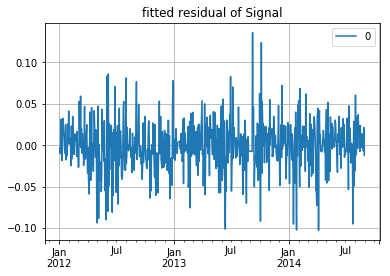

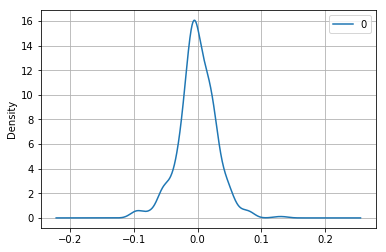

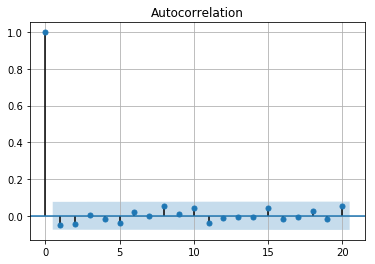

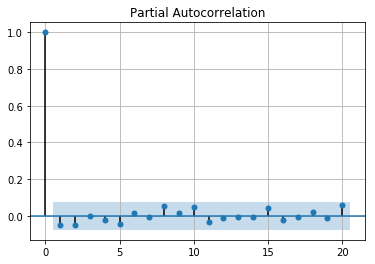

In [30]:
ar111.plot_residuals()

From the figures above, we can see that the residules follow the normal distribution. And no significant correlation are present, we can conclude that the residuals are independent. Overall, it seems to be a good fit. Let’s forecast.

We can also perform Ljung Box Test on the residues and the square values of residues.

In [31]:
print(sm.stats.acorr_ljungbox(ar111.model_fit.resid, lags=[1], return_df=True))

   lb_pvalue   lb_stat
1   0.183195  1.771512


In [32]:
print(sm.stats.acorr_ljungbox(ar111.model_fit.resid**2, lags=[1], return_df=True))

   lb_pvalue   lb_stat
1   0.749881  0.101631


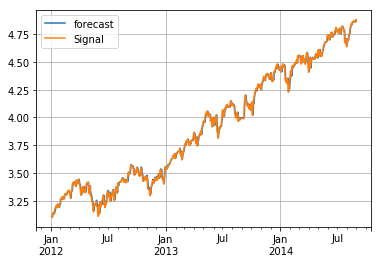

In [33]:
ar111.model_fit.plot_predict(dynamic=False)
plt.grid()
plt.show()

The above plot shows that the ARIMA(1,1,1) model can fit 'Signal' very well. Next let's use it to forecast 'ClosePrice' of SP500 to see if 'Signal' could be predictive of future returns of the SP500 index.

Let's use the last 100 rows of dataframe df as test set and the rest of the rows as training set. We use 'Signal' of the training set to train the ARIMA(1,1,1) model. Then we test the model by forecasting the 'ClosePrice' in the test set. Note that we divided the 'ClosePrice' by 38 to make 'ClosePrice' and 'Signal' equal at the starting date of the test set

                             ARIMA Model Results                              
Dep. Variable:           D.ClosePrice   No. Observations:                  568
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1182.385
Method:                       css-mle   S.D. of innovations              0.030
Date:                Mon, 20 Apr 2020   AIC                          -2356.770
Time:                        08:50:04   BIC                          -2339.401
Sample:                    01-04-2012   HQIC                         -2349.992
                         - 04-08-2014                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0027      0.000     12.672      0.000       0.002       0.003
ar.L1.D.ClosePrice     0.9696      0.011     89.483      0.000       0.948       0.991
ma.L1.D.ClosePrice  

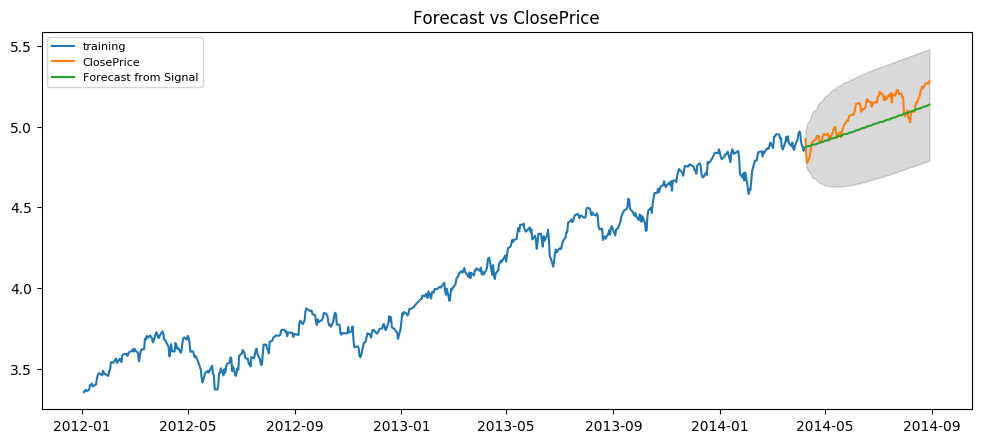

In [34]:
ar111.forecast(factor = 38, test_no=100)

From the figure above, the ARIMA(1,1,1) model seems to give a directionally correct forecast. And the actual observed 'ClosePrice' lie within the 95% confidence band.

In [36]:
ar111.forecast_accuracy()

{'mape': 0.017322513026562892,
 'corr': 0.8557742214558138,
 'minmax': 0.017311234266007558}

The MAPE, Correlation and Min-Max Error are used to evaluate the forcast. Around 1.7% MAPE implies the model is about 98.3% accurate in predicting the next 100 trading days. So I think this forcast is quite good.

# 3 Conclusion.

(1) From the data cleaning section. We find that there are 4 days which are illegal. 
- 2013-12-25 is Christmas Day
- 2014-01-01 is New Year's Day
- 2014-02-08 
- 2014-02-09 are weekends. 

What's more, there are 6 outliers in the 'Signal' column, which are 
- 2013-11-05
- 2013-11-06
- 2013-03-26
- 2014-04-14
- 2014-04-15
- 2014-04-16.

Also, there are 3 outliers in the 'ClosePrice' column, which are 
- 2013-09-12
- 2013-09-13
- 2013-09-16.

In addition, there are 6 missing dates which are actually trading days but are absent in the table. They are 
- 2013-01-14
- 2013-01-15
- 2013-01-16
- 2013-01-17
- 2014-01-06
- 2014-02-11

(2) By training the ARIMA model using 'Signal', we can predict future values of 'ClosePrice'. So 'Signal'can be predictive of future returns of the SP500 index (use SPY as a proxy).


However, we should tell the Portfolio Manager that 'ClosePrice' is approximately 40 times bigger than 'Signal'. We should calculate this factor today before we forecast the 'Closeprice' tomorrow.